In [8]:
#Importamos librerias base
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns


#Importamos el modelo de clasificación y las métricas
import sklearn.feature_selection as fs
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler

#Para la visualización
import graphviz 
import pydotplus
from IPython.display import Image

In [2]:
#Traemos el DataFrame
data = pd.read_csv('PVR_train_test.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   poblacion                                799 non-null    float64
 1   hogares                                  799 non-null    float64
 2   desocupado                               799 non-null    float64
 3   0-14                                     799 non-null    float64
 4   65_mas                                   799 non-null    float64
 5   inicial                                  799 non-null    float64
 6   primario                                 799 non-null    float64
 7   egb                                      799 non-null    float64
 8   secundario                               799 non-null    float64
 9   polimodal                                799 non-null    float64
 10  superior                                 799 non-n

In [20]:
#Generamos el x y el target

X= data.drop(['microzonificacion_Comercial',                   
'microzonificacion_Residencial suburbano',        
'microzonificacion_Residencial urbano',           
'macrozonificacion_Interfaz',                     
'macrozonificacion_Urbano', 'Target_NoApto', 'punto_tipo', 'ID','x','y'], axis=1)  
y= data['Target_NoApto']

#Hacemos el train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.25, stratify=y, random_state= 42)

undersampler=RandomUnderSampler(sampling_strategy='majority')

X_train_us,y_train_us=undersampler.fit_resample(X_train,y_train)

#Resultados
print('Chequeamos tamaños:')
print('')
print('Tamaño del train:', X_train.shape, y_train.shape, 'En %: ', X_train.shape[0]/X.shape[0])
print('Tamaño del test: ', X_test.shape, y_test.shape, 'En %: ', X_test.shape[0]/X.shape[0] )
print('')
print('Chequeamos stratify:')
print('')
print(y_train.value_counts()/y_train.shape[0])
print(y_test.value_counts()/y_test.shape[0])

Chequeamos tamaños:

Tamaño del train: (599, 19) (599,) En %:  0.7496871088861077
Tamaño del test:  (200, 19) (200,) En %:  0.2503128911138924

Chequeamos stratify:

1    0.689482
0    0.310518
Name: Target_NoApto, dtype: float64
1    0.69
0    0.31
Name: Target_NoApto, dtype: float64


C:\Users\DataScience\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass k=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\DataScience\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass k=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\DataScience\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass k=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\DataScience\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass k=4 as keyword args. From versi

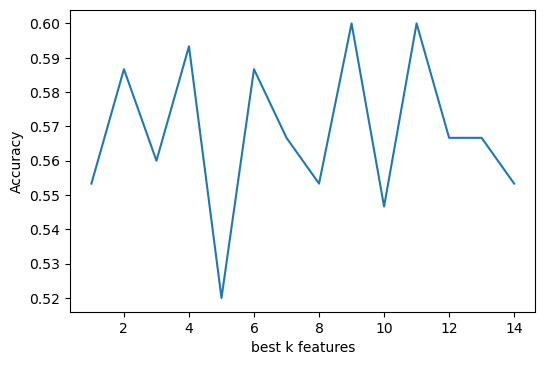

In [35]:
precision_list = []

for k in range(1, 15):
    
    bk = fs.SelectKBest(fs.f_classif, k)
    bk.fit(X_train, y_train)
    X_trans = bk.transform(X_train)
    train_x, test_x, train_y, test_y = train_test_split(X_trans,
                                                        y_train,
                                                        test_size=0.25,
                                                        random_state=42)


    undersampler=RandomUnderSampler(sampling_strategy='majority')

    X_train_us,y_train_us=undersampler.fit_resample(train_x,train_y)
    
    dtc = tree.DecisionTreeClassifier()
    dtc.fit(X_train_us, y_train_us)
    y_pred = dtc.predict(test_x)
    precision = metrics.accuracy_score(test_y, y_pred)
    precision_list.append(precision)

fig, axe = plt.subplots(dpi = 100)
axe.plot(range(1, 15), precision_list)
axe.set_xlabel("best k features")
axe.set_ylabel("Accuracy")
plt.show(fig)

In [21]:
sel_f = SelectKBest(f_classif, k=8)
X_train_f = sel_f.fit_transform(X_train_us, y_train_us)
Boolean= sel_f.get_support()
print(X_train.loc[:,Boolean].columns)

Index(['poblacion', 'desocupado', '65_mas', 'primario', 'secundario',
       'polimodal', 'lee_y _esc', 'NoLee_ni_e'],
      dtype='object')


In [13]:
#Inicializamos el modelo
clftree = tree.DecisionTreeClassifier()

In [27]:
#Hagamos un GridSearch con esta grilla
params_grid = { "criterion" : ["gini", "entropy"],
                "min_samples_leaf": [5,10,15,20,None], 
                "max_depth" : [1,2,3,4,5,6,8,9,10,11,12,13,14,None],
                "min_samples_split": [2, 3, 4,None]}

In [28]:
grid_search = GridSearchCV(clftree, params_grid,
                           n_jobs=-1, scoring='accuracy', cv= 10)

In [29]:
grid_search.fit(X_train_us, y_train_us)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13,
                                       14, None],
                         'min_samples_leaf': [5, 10, 15, 20, None],
                         'min_samples_split': [2, 3, 4, None]},
             scoring='accuracy')

In [30]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 15,
 'min_samples_split': 2}

In [31]:
cv_clf = grid_search.best_estimator_
cv_clf

DecisionTreeClassifier(max_depth=2, min_samples_leaf=15)

In [32]:
pd.DataFrame({'atributo':X.columns, 'importancia':cv_clf.feature_importances_}).sort_values('importancia', ascending = False)

ValueError: arrays must all be same length

In [33]:
#Score para el test
accuracy_score(y_test, cv_clf.predict(X_test))

ValueError: Number of features of the model must match the input. Model n_features is 14 and input n_features is 19 

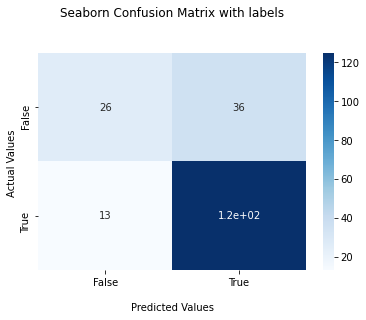

In [13]:
#Matriz de confusion
cf_matrix= confusion_matrix(y_test, cv_clf.predict(X_test))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [14]:
metrics.precision_score(y_test, cv_clf.predict(X_test))

0.7763975155279503

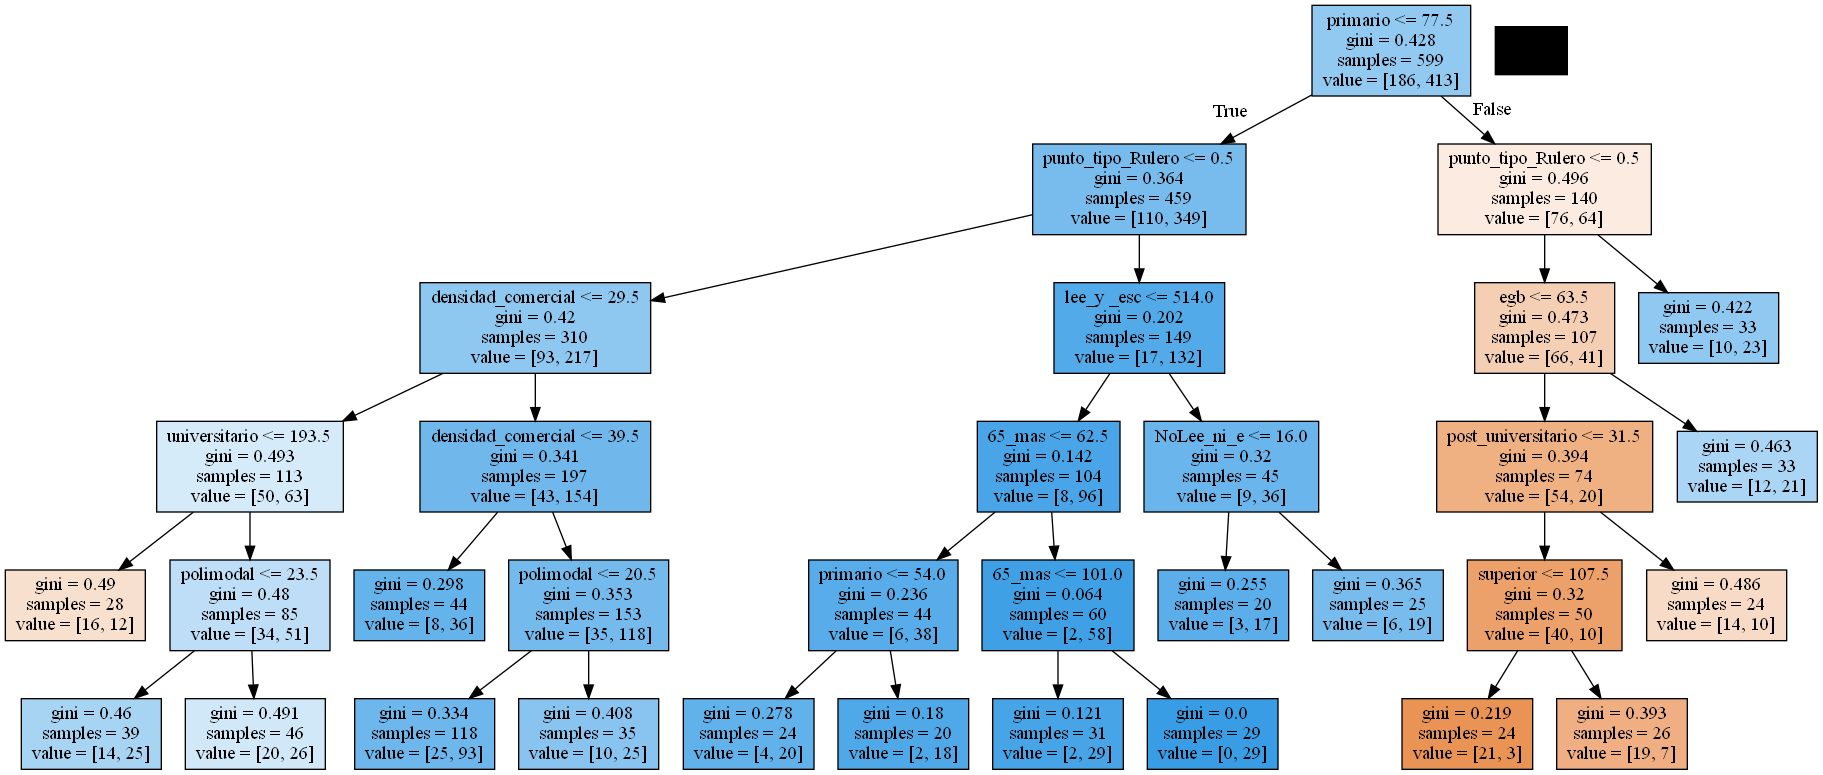

In [45]:
#Visualizamos el árbol
dot_data = tree.export_graphviz(cv_clf, out_file=None,feature_names= X.columns, filled = True)
graph2 = pydotplus.graph_from_dot_data(dot_data)
Image(graph2.create_png())

Oversampling con SMOTE

In [3]:
#Traemos el DataFrame sin dummies
data_sindummies = pd.read_csv('PVR_train_test_sindummies.csv')

In [4]:
data_sindummies

,Tipo de punto,Target,TipoResiduo,CantidadNum,¿Se realiza recolección en el momento?,poblacion,hogares,desocupado,0-14,65_mas,...,NoLee_ni_e,hacinamiento,sin_agua,sin_cloaca,densidad_comercial,microzonificacion,macrozonificacion,x,y,index
0,Punto Verde,Apto,Papel,2.0,Sí,620.0,215.0,17.0,101.0,103.0,...,22.0,1.0,0.0,0.0,7.0,Residencial urbano,Urbano,-68.85207,-32.87347,10.0
1,Punto Verde,Apto,"Vidrio, Metal, Tetra",2.0,Sí,620.0,215.0,17.0,101.0,103.0,...,22.0,1.0,0.0,0.0,7.0,Residencial urbano,Urbano,-68.85207,-32.87347,10.0
2,Punto Verde,Apto,Plástico,2.0,Sí,620.0,215.0,17.0,101.0,103.0,...,22.0,1.0,0.0,0.0,7.0,Residencial urbano,Urbano,-68.85207,-32.87347,10.0
3,Punto Verde,Apto,Papel,3.0,Sí,985.0,375.0,38.0,161.0,145.0,...,35.0,1.0,0.0,3.0,17.0,Residencial urbano,Urbano,-68.84756,-32.87072,5.0
4,Punto Verde,Apto,"Vidrio, Metal, Tetra",3.0,Sí,985.0,375.0,38.0,161.0,145.0,...,35.0,1.0,0.0,3.0,17.0,Residencial urbano,Urbano,-68.84756,-32.87072,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,Rulero,NoApto,PET,1.0,Sí,528.0,188.0,11.0,87.0,102.0,...,16.0,0.0,0.0,0.0,10.0,Residencial urbano,Urbano,-68.84837,-32.90143,70.0
794,Rulero,NoApto,PET,1.0,Sí,528.0,188.0,11.0,87.0,102.0,...,16.0,0.0,0.0,0.0,10.0,Residencial urbano,Urbano,-68.84837,-32.90143,70.0
795,Rulero,NoApto,PET,1.0,Sí,528.0,188.0,11.0,87.0,102.0,...,16.0,0.0,0.0,0.0,10.0,Residencial urbano,Urbano,-68.84837,-32.90143,70.0
796,Rulero,NoApto,PET,1.0,Sí,528.0,188.0,11.0,87.0,102.0,...,16.0,0.0,0.0,0.0,10.0,Residencial urbano,Urbano,-68.84837,-32.90143,70.0


In [6]:
#Hacemos el train_test_split con las variables categóricas
X_train_cat, X_test_cat, y_train, y_test = train_test_split(data_sindummies.drop('Target', axis=1), data_sindummies['Target'], stratify = data_sindummies['Target']
                                                           ,random_state= 99)

In [7]:
from imblearn.over_sampling import SMOTENC

In [8]:
categorical_cols=(X_train_cat.dtypes=='object').values
numerical_cols= ~categorical_cols

sm=SMOTENC(categorical_features=categorical_cols,k_neighbors=5,random_state=0)
X_train_sm,y_train_sm=sm.fit_resample(X_train_cat,y_train)

In [9]:
print('Balance de clases:')
print(y_train_sm.value_counts(normalize=False))

Balance de clases:
Apto      413
NoApto    413
Name: Target, dtype: int64


In [12]:
enc=OneHotEncoder(drop='first',sparse=False)
train_dummies=enc.fit_transform(X_train_sm.loc[:,categorical_cols])
train_dummies=pd.DataFrame(train_dummies)
train_dummies.columns=[x for cat_list in enc.categories_ for x in cat_list[1:]]

X_train_final=X_train_sm.loc[:,numerical_cols].join(train_dummies)

test_dummies=enc.transform(X_test_cat.loc[:,categorical_cols])
test_dummies=pd.DataFrame(test_dummies)
test_dummies.columns=[x for cat_list in enc.categories_ for x in cat_list[1:]]
test_dummies.index=X_test.index

X_test_final=X_test_cat.loc[:,numerical_cols].join(test_dummies)

print(X_train_final.shape)
print(X_test_final.shape)

(826, 33)
(200, 33)


In [17]:
grid_search.fit(X_train_final, y_train_sm)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13,
                                       14, None],
                         'min_samples_leaf': [5, 10, 15, 20, None],
                         'min_samples_split': [2, 3, 4, None]},
             scoring='accuracy')

In [18]:
cv_clf_os = grid_search.best_estimator_
cv_clf_os

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=10,
                       min_samples_split=3)

In [19]:
#Score para el test
accuracy_score(y_test, cv_clf_os.predict(X_test_final))

TypeError: '<' not supported between instances of 'str' and 'int'

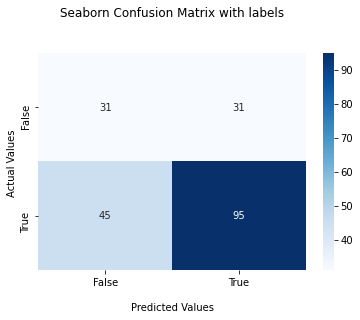

In [37]:
#Matriz de confusion
cf_matrix= confusion_matrix(y_test, cv_clf_os.predict(X_test_final))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

OVERSAMPLING DONT GIVE GOOD RESULTS!

In [15]:
#Importamos
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

Random Forest

In [16]:
#Instanciamos el modelo y ajustamos los datos 
rf_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1)

In [17]:
#Vemos accuracy y matriz de confusión
print(confusion_matrix(y_test, rf_clf.predict(X_test)))
print('')
print('The Random Forest score is: ', accuracy_score(y_test, rf_clf.predict(X_test)))
print('The Random Forest precision is: ', metrics.precision_score(y_test, rf_clf.predict(X_test)))

[[ 26  36]
 [ 13 125]]

The Random Forest score is:  0.755
The Random Forest precision is:  0.7763975155279503


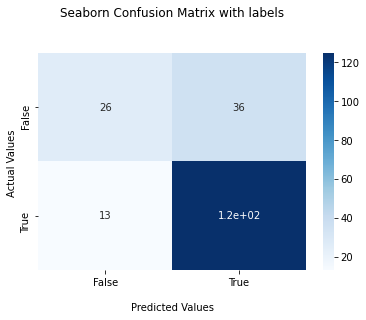

In [18]:
#Matriz de confusion
cf_matrix= confusion_matrix(y_test, rf_clf.predict(X_test))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Bagging 

In [19]:
bag_clf = BaggingClassifier(base_estimator=clftree, n_estimators=1000,
                            bootstrap=True, n_jobs=-1,
                            random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=1000,
                  n_jobs=-1, random_state=42)

In [20]:
print(confusion_matrix(y_test, bag_clf.predict(X_test)))
print('')
print('The Bagging score is: ', accuracy_score(y_test, bag_clf.predict(X_test)))
print('The Bagging score is: ', metrics.precision_score(y_test, bag_clf.predict(X_test)))

[[ 26  36]
 [ 13 125]]

The Bagging score is:  0.755
The Bagging score is:  0.7763975155279503


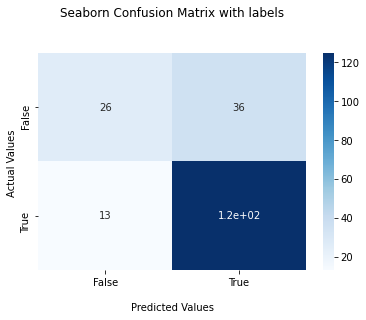

In [21]:
#Matriz de confusion
cf_matrix= confusion_matrix(y_test, bag_clf.predict(X_test))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

AdaBoost

In [22]:
AdaBoost = AdaBoostClassifier (
           tree.DecisionTreeClassifier(max_depth=1), n_estimators= 1000
)

AdaBoost.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=1000)

In [23]:
predictions = AdaBoost.predict(X_test)

In [24]:
print(confusion_matrix(y_test, predictions))
print('')
print('The AdaBoost score is: ', accuracy_score(y_test, predictions))
print('The AdaBoost precision is: ', metrics.precision_score(y_test, predictions))

[[ 26  36]
 [ 13 125]]

The AdaBoost score is:  0.755
The AdaBoost precision is:  0.7763975155279503


Gradient Boosting

In [25]:
parameters = {'n_estimators':[500, 1000] , 
             'learning_rate':[0.001, 0.001, 0.1],
            'max_depth' : [1, 2, 3, 4]}

In [26]:
GB_clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

In [27]:
GB_clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.001, 0.1],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [500, 1000]})

In [28]:
print(GB_clf.best_params_)
print('The Gradient Boosting score is: ', accuracy_score(y_test, GB_clf.predict(X_test)))
print('The AdaBoost precision is: ', metrics.precision_score(y_test, GB_clf.predict(X_test)))

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}
The Gradient Boosting score is:  0.755
The AdaBoost precision is:  0.7763975155279503
